## Example CTD data handling 
### Eddy near Japan
We explored an area near Japan with the CTD device onboard the Virtualship. It measured salinity, temperature and pressure up to 2000 metres depth. In this tutorial you can see how we process the data and interpolate to create crosssections.

In [1]:
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import cmocean

In [ ]:
# Download data
import requests

files = {
    "Japan.zip": "https://surfdrive.surf.nl/files/index.php/s/1EOYBwfh1y68h79/download"
}

for filename, url in files.items():
    response = requests.get(url, allow_redirects=True)

    if response.status_code == 200:
        with open(filename, "wb") as f:
            f.write(response.content)
    else:
        print("Failed to download", url)
print("Download ready")

# unpack the downloaded data
!unzip -q Japan.zip -d . 

First we will have to read the _csv_ files. Take a look at the comments and header of the first CTD dataset by running the following cell.

In [2]:
header = pd.read_csv("Japan/CTD_Japan_station_1.csv", nrows=5, header=None)
header

,0,1,2
0,longitude,154.0,"{'axis': 'X', 'long_name': '', 'standard_name'..."
1,latitude,38.099998474121094,"{'axis': 'Y', 'long_name': '', 'standard_name'..."
2,start time,2022-10-18T00:00:00.000000000,NaN
3,end time,2022-10-18T01:06:20.000000000,NaN
4,pressure [hPa],temperature [degC],salinity [g kg-1]


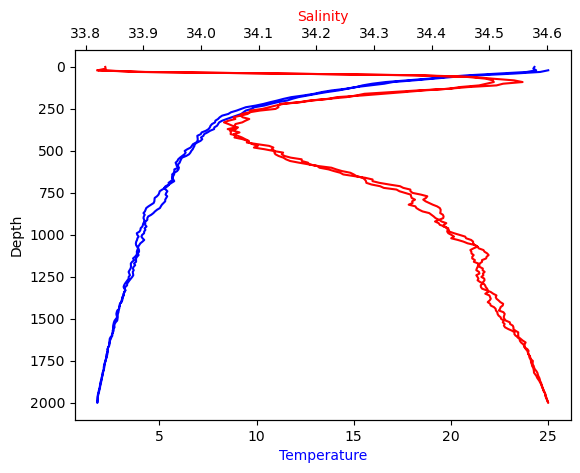

In [3]:
# Read in data
P, T, S = np.loadtxt(
    "Japan/CTD_Japan_station_1.csv", delimiter=",", skiprows=5, unpack=True
)
# for simplicity we assume a depth-pressure conversion factor of 1 (dbar = 1 m)
z = P * 10  # convert pressure from hPa to m

# Plot the data
fig, ax1 = plt.subplots(1, 1)

# Plot temperature on the first x-axis in blue
ax1.plot(T, z, color="blue")
ax1.invert_yaxis()  # depth increases downwards
ax1.set_xlabel("Temperature", color="blue")
ax1.set_ylabel("Depth")

# Plot salinity on the second x-axis in red
ax2 = ax1.twiny()  # ax1 and ax2 share y-axis
ax2.plot(S, z, color="red")
ax2.set_xlabel("Salinity", color="red")

plt.show()

### Thermocline
The thermocline is typically characterized by a sharp decrease in temperature compared to the layers above and below it. Look at your temperature vs. depth plot and compare the temperature characteristics of the potential thermocline to the layers above and below. The thermocline should stand out as a distinct transition layer where the temperature gradient is steeper. In addition to temperature, consider other parameters such as salinity. The thermocline is often associated with changes in other properties as well. Analyzing multiple variables can help you indentify the thermocline and provide a more comprehensive understanding of the ocean's vertical structure. 

### Xarray
To load the data in _xarray's_ useful format, we first create a new dataset with empty data. The dimensions _trajectory_ and _obs_ represent the length of each measurement and the number of measurements, respectively.

In [9]:
# To load the data in _xarray's_ useful format, we first create a new dataset with empty data. The dimensions _trajectory_ and _obs_ represent the length of each measurement and the number of measurements, respectively.
ctd = xr.Dataset(
    data_vars={
        "P": (
            ("trajectory", "obs"),
            np.zeros((399, 5)),
            {"long_name": "pressure", "units": "hPa"},
        ),
        "T": (
            ("trajectory", "obs"),
            np.zeros((399, 5)),
            {"long_name": "temperature", "units": "degC"},
        ),
        "S": (
            ("trajectory", "obs"),
            np.zeros((399, 5)),
            {"long_name": "salinity", "units": "g kg-1"},
        ),
    },
    coords={
        "trajectory": ("trajectory", range(399)),
        "obs": ("obs", range(1, 6)),
        "lat": (
            "obs",
            np.zeros((5)),
            {"long_name": "latitude", "units": "degrees_north"},
        ),
        "lon": (
            "obs",
            np.zeros((5)),
            {"long_name": "longitude", "units": "degrees_east"},
        ),
        "start_time": (
            "obs",
            np.zeros((5), dtype="<M8[ns]"),
            {"long_name": "start_time"},
        ),
        "end_time": ("obs", np.zeros((5), dtype="<M8[ns]"), {"long_name": "end_time"}),
    },
)

In [16]:
# Fill the dataset with values from the csv files.
for ob in range(5):  # loop through files
    header = pd.read_csv(f"Japan/CTD_Japan_station_{ob + 1}.csv", nrows=7, header=None)
    ctd.lon[ob] = header.iloc[0, 1]
    ctd.lat[ob] = header.iloc[1, 1]
    ctd.start_time[ob] = header.iloc[2, 1]
    ctd.end_time[ob] = header.iloc[3, 1]
    data = pd.read_csv(f"Japan/CTD_Japan_station_{ob + 1}.csv", skiprows=4)
    ctd.P[:, ob] = data["pressure [hPa]"]
    ctd.T[:, ob] = data["temperature [degC]"]
    ctd.S[:, ob] = data["salinity [g kg-1]"]

In [11]:
# Integrate the hydrostatic balance equation to compute the depth z (negative everywhere) for all measurements. Use the TEOS10 approximation for density and add depth and density as variables to the dataset. Plot z for one of the CTD casts.

g = 9.81
CT = gsw.CT_from_t(ctd.S, ctd.T, ctd.P)
Rho = gsw.density.rho(ctd.S, CT, ctd.P)
Pa = 100000 * ctd.P  # bar to Pa
Pa0 = Pa.isel(trajectory=0)
Rho0 = Rho.isel(trajectory=0)
ctd["Rho"] = Rho.assign_attrs(
    {"long_name": "density", "standard_name": "density", "units": "kg m-3"}
)

# calculate z (xarray style)
Rhoc = Rho.rolling(trajectory=2).mean().dropna("trajectory")  # rho grid center
dz = (-1 / (g * Rhoc)) * Pa.diff("trajectory")
z = xr.concat(
    (xr.zeros_like(Pa0), dz.cumulative("trajectory").sum()), "trajectory"
) - Pa0 / (Rho0 * g)
ctd["z"] = xr.DataArray(
    z.data, z.coords, z.dims, attrs={"long_name": "depth", "units": "m"}
).transpose(*ctd.dims)

# # alternatively (numpy style, perhaps more intuitive)
# ctd['z'] = xr.zeros_like(ctd.Rho).assign_attrs({
#     'long_name':'depth','standard_name':'depth','units':'m'})
# for ob in range(5): # loop through obs
#     rho = ctd.Rho[:,ob]
#     rhoc = np.mean((rho[1:], rho[:-1]),axis=0)
#     dz = -1/(g*rhoc)*np.diff(Pa[:,ob])
#     ctd.z[0,ob] = -Pa[0,ob]/(rho[0]*g)
#     for tj in range(len(ctd.z)-1): # loop through trajectory
#         ctd.z[tj+1,ob] = ctd.z[tj,ob] + dz[tj]

In [13]:
# Selecting the data during ascent and interpolating to depth levels every five metres.
print(
    "index (trajectory) of minimum depth:", ctd.z.argmin("trajectory").data, "(obs: 5)"
)
trup = dict(trajectory=slice(200, None))
ctd_up = ctd.isel(trup)  # select ascending portion


def interp_1d(fp, xp, x):
    """interpolate fp(xp) to x

    args:
    fp : array(k)
        variable to interpolate
    xp : array(k)
        coordinates of fp
    x : array(k)
        new coordinates of interpolated variable

    returns:
    array(k)
        values of fp interpolated to x
    """
    return np.interp(x, xp, fp)


zlev = np.arange(-5, -2000, -10)  # new depth levels
ctd_interp = xr.apply_ufunc(
    interp_1d,  # function to apply along core dimension
    ctd_up,  # arg1
    ctd_up.z,  # arg2
    zlev,  # arg3
    input_core_dims=[
        ["trajectory"],
        ["trajectory"],
        ["zlev"],
    ],  # core dimension per arg
    output_core_dims=[["zlev"]],  # core dimension output
    exclude_dims=set(["trajectory"]),  # input dimension that may disappear in output
    vectorize=True,  # vectorizes args so interp_1d receives one-dimensional data
    keep_attrs=True,  # keep array attributes
    on_missing_core_dim="copy",  # how to handle possibly missing core dims on input
)
ctd_interp = ctd_interp.drop_vars("z").assign_coords(
    {"z": ("zlev", zlev, ctd_interp.z.attrs)}
)  # set z as 1D coord

index (trajectory) of minimum depth: [200 200 200 200 200] (obs: 5)


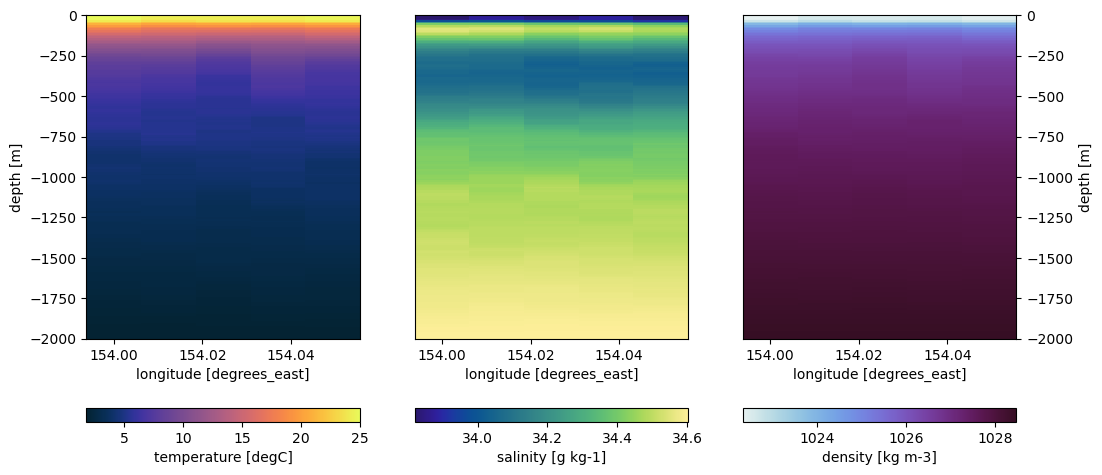

In [14]:
# Plot vertical cross sections of temperature, salinity and density with longitude and depth on the x- and y-axis, respectively.
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132, sharey=ax1)
ax2.yaxis.set_visible(False)
ax3 = fig.add_subplot(133, sharey=ax1)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ctd_interp.T.plot(
    ax=ax1,
    x="lon",
    y="z",
    cmap=cmocean.cm.thermal,
    cbar_kwargs={"orientation": "horizontal"},
)
ctd_interp.S.plot(
    ax=ax2,
    x="lon",
    y="z",
    cmap=cmocean.cm.haline,
    cbar_kwargs={"orientation": "horizontal"},
)
ctd_interp.Rho.plot(
    ax=ax3,
    x="lon",
    y="z",
    cmap=cmocean.cm.dense,
    cbar_kwargs={"orientation": "horizontal"},
)

Text(0.5, 1.0, 'vertical shear of meridional velocity')

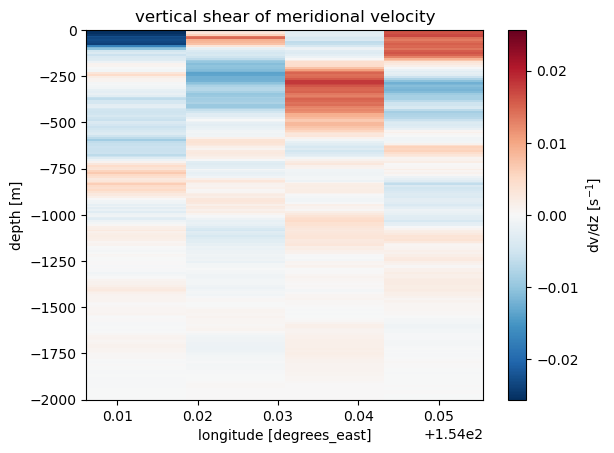

In [15]:
# Calculate and plot the vertical shear of the meridional velocity, assuming the flow is in thermal wind balance.
Re = 6371000  # radius earth [m]
Om = 2 * np.pi / (86400)  # angular frequency earth [s-1]

latr = np.deg2rad(ctd_interp.lat)  # latitude (rad)
lonr = np.deg2rad(ctd_interp.lon)  # longitude (rad)
dlonr = lonr.diff("obs")  # longitude difference between casts (rad)
dx = Re * np.cos(latr) * dlonr  # distance between cast locations (m)
f = 2 * Om * np.sin(latr)  # coriolis parameter

rho = ctd_interp.Rho  # density (kg m-3)
drho = rho.diff("obs")  # density difference between casts (kg m-3)
dvdz = -g / (f * rho) * drho / dx  # vertical shear of meridional flow (m s-1)

# plot the vertical shear of meridional velocity
dvdz.plot.pcolormesh(x="lon", y="z", cbar_kwargs={"label": r"dv/dz [s$^{-1}$]"})
plt.title("vertical shear of meridional velocity")